Storage Folder for videos


In [1]:
output_folder = "/mnt/Personal/Projects/Drivator"

Imported Libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random
from tqdm import tqdm
from IPython.display import clear_output
from collections import deque
import copy

Envionmental Constants in Class

In [3]:
def normalize_radian(rad):
    
    if  -np.pi <= rad <= np.pi: 
        return rad
    else:
        return (rad + np.pi) % (2 * np.pi) - np.pi

In [4]:
import numpy as np

class PointProperties:
    
    def __init__(self,origin=[0,0],direction_angle=0,gear_alpha=0.01,acceleration=0,min_dist=0,max_angle= 0,max_speed=0,speed=0):
        
        self.x = origin[0]
        self.y = origin[1]
        
        self.angle = normalize_radian(direction_angle)
        
        self.alpha = gear_alpha
        self.accel = acceleration
        
        self.speed=speed
        self.max_speed=max_speed
        
        self.min_dist = min_dist
        
        self.max_error_angle = max_angle
        
    def get_point(self):
        
        return self.x,self.y
    
    def move_point(self,dx=0,dy=0):
        
        self.x+=dx
        self.y+=dy
        
    def set_point(self,x=0,y=0):
        
        self.x=x
        self.y=y
        
    def get_angle(self):
        return self.angle
        
    def set_angle(self,new_angle):
        
        self.angle=new_angle
        self.angle = normalize_radian(self.angle)
        
    def get_speed(self):
        return self.speed
        
    def set_speed(self,speed):
        self.speed = speed
        
    def get_max_speed(self):
        return self.max_speed
        
    def set_max_speed(self,max_speed):
        self.max_speed = max_speed
        
    def get_alpha(self):
        return self.alpha
        
    def set_alpha(self,alpha):
        self.alpha = alpha
        
    def get_max_error_angle(self):
        return self.max_error_angle
        
    def set_max_error_angle(self,max_error):
        self.max_error_angle = max_error
        
    def get_min_dist(self):
        return self.min_dist
        
    def set_min_dist(self,min_dist):
        self.min_dist = min_dist
        
    def get_acceleration(self):
        return self.accel
        
    def set_acceleration(self,accel):
        self.accel = accel

class MapConstraints:
    
    def __init__(self):
        
        self.constraints=[]
        
    def set_constraints_list(self,point_list):
        self.constraints = point_list
        
    def set_constraints_point(self,index,point):
        self.constraints[index] = point
        
    def get_constraints(self,index):
        if index==len(self.constraints):
            index-=1
        return self.constraints[index]
    
    def get_constraints_list(self):
        return self.constraints
    
    def get_last_constraint(self):
        return self.constraints[-1]

class MapMatrix:
    def __init__(self, n):
        self.size = n
        self.shape = (self.size, self.size)
        
        self.map_matrix = np.full(self.shape, 0, dtype=int)
        
    def index_within_bounds(self,x,y):
        
        return (0 <= x < self.shape[0]) and (0 <= y < self.shape[1])
        
    def refill(self,n,m):
        self.shape=(n,m)
        self.map_matrix = np.full(self.shape, 0, dtype=int)
        self.shape = (n, m)
        

        
    def set_value(self, x, y, val):
        
        try:
            self.map_matrix[x][y] = val
        except:
            raise IndexError("Coordinates out of bounds")
            # return 0

    def get_value(self, x, y):
        
        try:
            return self.map_matrix[x][y]
        except:
            # raise IndexError("Coordinates out of bounds")
            return 0
                    
    def get_matrix(self):
        return self.map_matrix

    def get_size(self):
        return self.shape

POINT = PointProperties()
map_matrix = MapMatrix(n=2000)
const_point = MapConstraints()

Experimentable Functions


In [5]:
def get_angle_from_speed(speed):
    
    max_speed=POINT.get_max_speed()
    max_error_angle = POINT.get_max_error_angle()
    alpha = POINT.get_alpha()
    
    speed = min(speed,max_speed)
    
    def theta(alpha,v_max,v):
        return np.arcsin((alpha*v_max)/v)
    
    dev_angle = 0
    
    if speed <= (alpha*max_speed):
        dev_angle = max_error_angle
    else:
        dev_angle = theta(alpha,max_speed,speed) * (max_error_angle/(np.pi/2))
        
    if np.isnan(dev_angle):
        dev_angle=max_error_angle
        
    angle = normalize_radian(dev_angle)
    
    return angle

def get_speed_from_angle(delta_angle):
    
    max_speed=POINT.get_max_speed()
    max_error_angle = POINT.get_max_error_angle()
    alpha = POINT.get_alpha()
    
    delta_angle = abs(normalize_radian(delta_angle))
    
    if (delta_angle>max_error_angle):
        return 0
    
    def vel(alpha, v_max, theta):
        return (alpha*v_max)/np.sin(theta)
    
    speed = 0
    
    if np.sin((delta_angle*np.pi)/(max_error_angle*2)) < alpha:
        speed = max_speed
    else :
        speed = vel(alpha,max_speed,(delta_angle*np.pi)/(max_error_angle*2))
        
    
    speed = min(max_speed,speed)
    
    return speed

In [6]:
def get_center_speed(prev_speed,speed,dt):
    
    accel=POINT.get_acceleration()
    
    max_dev = accel*dt
    speed_dev = speed - prev_speed
    
    if abs(speed_dev)>abs(max_dev):
        speed_dev = np.sign(speed_dev)*abs(max_dev)
        
    fin_speed = prev_speed+speed_dev
        
    return fin_speed

def get_gyro_angle(speed,prev_angle,angle):
    
    max_dev = get_angle_from_speed(speed)
    
    angle_dev = angle - prev_angle
    
    if abs(angle_dev)>abs(max_dev):
        angle_dev = np.sign(angle_dev)*abs(max_dev)
        
    fin_angle = prev_angle+angle_dev
    
    return fin_angle

Helper Functions

In [7]:

def index_to_point(i, j):
    
    min_dist = POINT.get_min_dist()

    i, j = i*min_dist, j*min_dist

    return i, j


def point_to_index(x, y):
    # print(origin)
    min_dist = POINT.get_min_dist()

    x, y = (x)/min_dist, (y)/min_dist

    x, y = int(round(x)), int(round(y))

    return x, y


def round_off_step(x):

    min_dist = POINT.get_min_dist()


    step = 1/min_dist

    sign = np.sign(x)
    x = abs(x)

    int_x = int(x)
    frac_x = x-int(x)

    idx = round(frac_x*step)/step

    y = sign*(int_x + idx)

    return y


Find nearest point using approximation

In [8]:
def find_intersection(theta, max_look):
    
    pos_x,pos_y = POINT.get_point()
    
    dest_x = pos_x + np.cos(theta) * max_look
    dest_y = pos_y + np.sin(theta) * max_look

    pos_i, pos_j = point_to_index(pos_x, pos_y)
    dest_i, dest_j = point_to_index(dest_x, dest_y)
    
    default_value = 0 if map_matrix.get_value(pos_i,pos_j)!=0 else -1

    x0, y0, x1, y1 = pos_i, pos_j, dest_i, dest_j
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        
        if x0 == x1 and y0 == y1:
            break
        
        nx = x0
        ny = y0
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            nx = x0 + sx
        if e2 < dx:
            err += dx
            ny = y0+sy
            
        if not map_matrix.index_within_bounds(nx,ny):
            break
        
        if map_matrix.get_value(nx,ny) == default_value:
            break
        
        x0=nx
        y0=ny
            
    ax,ay = pos_x,pos_y
    bx,by = index_to_point(x0,y0)
    
    dist = np.sqrt((ax-bx)**2+(ay-by)**2)
    point = [bx,by]
    

    return dist,point
    

Getting points for the bounded region


In [9]:
def get_path_list():

    size = map_matrix.get_size()
    
    x_list=[]
    y_list=[]
    
    for i in tqdm(range(size[0])):
        for j in range(size[1]):
            
            if map_matrix.get_value(i,j)!=0:
                
                x,y = index_to_point(i,j)
                x_list.append(x)
                y_list.append(y)

    return x_list, y_list

Error Calculating Fucntions


In [10]:


def get_dist_angle(dest_index):
    
    pos_x,pos_y = POINT.get_point()
    
    pos_i,pos_j= point_to_index(pos_x,pos_y)
    
    temp_index=map_matrix.get_value(pos_i,pos_j)
    dest_index = temp_index if temp_index!=0 else dest_index
    
    destination = const_point.get_constraints(dest_index)
    dest_x,dest_y = destination[0],destination[1]

    dist = np.sqrt((dest_x-pos_x)**2 + (dest_y-pos_y)**2)
    
    angle = np.arctan2((dest_y-pos_y), (dest_x-pos_x))


    return dest_index, dist, angle

def get_boundary_boolean(theta, max_dist):
    
    min_dist= POINT.get_min_dist()
    
    bound, _ = find_intersection(theta,max_dist)
    
    return bound, bound >= (max_dist-min_dist)
    
def error_calculation(dest,dt):
    # max_dist=straight_bound
    theta = POINT.get_angle()
    speed = POINT.get_speed()
    accel =POINT.get_acceleration()
    straight_bound = (speed**2)/(2*accel)
    # max_speed = POINT.get_max_speed()
    
    min_angle_dev = get_angle_from_speed(speed+accel*dt)
    
    _,_,dest_angle = get_dist_angle(dest)
    
    dev_angle = 0
    
    boundary,bound_min_bool = get_boundary_boolean(theta,straight_bound)
            
    if bound_min_bool:
        
        if abs(dest_angle-theta)<min_angle_dev:
            return 0,boundary
        
        if (dest_angle-theta)>0:
            return min_angle_dev,boundary
        else:
            return -min_angle_dev,boundary
    
    for i in range(0,180,5):
        
        angle = (i*2*np.pi)/360.0
        delta_move = theta - dest_angle
        
        prob_speed = get_speed_from_angle((dest_angle+dev_angle)-theta)
        prob_speed = min(prob_speed,speed)
        prob_dist = (prob_speed**2)/(2*accel)
        prob_dist = min(prob_dist,straight_bound)
        # prob_dist=4
        
        if (i==0):
            _,d = get_boundary_boolean(dest_angle, prob_dist)
            
            if d:
                dev_angle=0
                break
            else:
                continue
        
        _,dr = get_boundary_boolean(dest_angle-angle, prob_dist)
        _,dl = get_boundary_boolean(dest_angle+angle, prob_dist)
        
        if dl and dr :
            
            if delta_move > angle:
                dev_angle = +angle
            elif delta_move < -angle:
                dev_angle = -angle
            
        elif dl:
            dev_angle = +angle
        elif dr:
            dev_angle = -angle
                
        if dl or dr:
            break
    
    error_angle = (dest_angle+dev_angle)-theta
    error_angle = normalize_radian(error_angle)
    
    # print(np.rad2deg(error_angle))
    
    return error_angle,boundary


        

def reached_end(fin,threshold):
    
    x,y = POINT.get_point()
    
    fx,fy = fin[0],fin[1]
    
    val = np.sqrt((fx-x)**2+ (fy-y)**2)
    
    return val<=threshold

Plotting Function


In [11]:
def plotter(positions, y_axis, max_trail, x_bound, y_bound, bound, 
            plotter_x, plotter_y):
    
    pos_x, pos_y = POINT.get_point()
    speed = POINT.get_speed()
    
    const_points = const_point.get_constraints_list()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Customize axes
    if not y_axis:
        ax.yaxis.set_visible(False)
    else:
        ax.tick_params(axis='y', colors='white')

    ax.tick_params(axis='x', colors='white')

    # plot the ball and its trail
    ball, = ax.plot([], [], 'ro', markersize=10)
    trail, = ax.plot([], [], 'r-', linewidth=1)

    ax.set_xlim(pos_x - x_bound, pos_x + x_bound)
    ax.set_ylim(pos_y - y_bound, pos_y + y_bound)

    # update ball and trail positions
    i = len(positions) - 1
    pos_x, pos_y = positions[i]
    xs, ys = zip(*positions[max(0, i - max_trail):i + 1])

    ball.set_data([pos_x], [pos_y])
    trail.set_data(xs, ys)

    # plot the points as small white circles (marker size 0.2)
    ax.plot(plotter_x, plotter_y, 'o', color='white', markersize=0.2, markeredgecolor='white')

    # plot const_points as blue circles (marker size 2)
    if len(const_points)!=0:
        const_x, const_y = zip(*const_points)
        ax.plot(const_x, const_y, 'o', color='blue', markersize=2, markeredgecolor='blue')

    ax.text(0.95, 0.95, f"Speed = {speed:.3f}, Bound = {bound:.3f}",
            transform=ax.transAxes, fontsize=12, color='white', ha='right', va='top')

    return fig, ax


PID Class


In [12]:
# PID Controller class
class PID:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = 0
        self.prev_error = 0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
            
        return output

Simulator Function


In [13]:


def simulate_particle(speed_up_ratio=1.0, delta_time=0.0, 
                    fps=20, y_axis=True, show_gif=False, x_bound=5, y_bound=5,
                    stab_dist=0.5, max_trail=500):
    
    
    
    
    plotter_x,plotter_y = get_path_list()

    fps = fps//speed_up_ratio
    
    if delta_time==0.0:
        dt = POINT.get_min_dist()/POINT.get_max_speed()
    else:
        dt= delta_time

    frame_wait = 1/(fps)
    frame = 0
    
    destination_point = const_point.get_last_constraint()     
    
    pid_angle_k = [100,0,0]
    pid_speed_k = [100,0,0]
    
    pid_angle = PID(Kp=pid_angle_k[0], Ki=pid_angle_k[1], Kd=pid_angle_k[2])
    
    pid_speed = PID(Kp=pid_speed_k[0], Ki=pid_speed_k[1], Kd=pid_speed_k[2])

    

    
    dest_index=0

    start_time = time.time()

    total_time = 0
    average_wait=0
    average_speed=0
    speed_counter=0
    average_counter = 0
    
    positions = [POINT.get_point()]
    
    acceleration = POINT.get_acceleration()
    min_dist = POINT.get_min_dist()
    max_speed = POINT.get_max_speed()

    while True:
        
        #############
        # Initialization
        
        speed = POINT.get_speed()
        angle = POINT.get_angle()
        
        ###############
        
        
        prev_speed = speed
        prev_angle = angle
        
        if reached_end(destination_point,stab_dist):
            break
        
        
        #############
        # Accident
        
        ###############
            
            
        ###############
        # Error Calculation
        
        straight_bound = (speed**2)/(2*acceleration)
        
        error_angle,bound = error_calculation(dest_index,dt)
        
        probable_speed = 0
        
        if bound > (straight_bound - min_dist):
            probable_speed = get_speed_from_angle(error_angle)
        else:
            probable_speed = np.sqrt(bound * 2 * acceleration)
        
        error_speed = probable_speed - speed
        
        ###############


        ###############
        # Movement Calculation
        
        corr_angle = pid_angle.update(error_angle, dt) * dt
        
        angle+=corr_angle
        
        corr_angle= normalize_radian(corr_angle)
        
        
        # print(np.rad2deg(corr_angle))
        
        
        
        corr_speed = pid_speed.update(error_speed,dt) * dt
        
        speed += corr_speed
        speed = min (speed,max_speed)

        
        ##################
        
        ##################
        # Send Data to Motors
        
        ##################
        
        
        
        ##################
        # Get sensor data
        
        # print(speed)
        
        speed = get_center_speed(prev_speed,speed,dt)
        angle = get_gyro_angle(prev_speed,prev_angle,angle)
        
        POINT.set_speed (speed)
        POINT.set_angle(angle)
        
        ###################
        
        
        
        ###################
        # Simulating path
        
        speed = POINT.get_speed()
        angle = POINT.get_angle()

        travel_dist = dt*speed
        
        dx = travel_dist * np.cos(angle)
        dy = travel_dist * np.sin(angle)
        
        POINT.move_point(dx,dy)
        
        positions.append(POINT.get_point())

        total_time += dt
        
        average_speed+=speed
        speed_counter+=1
        
        ##################
        
        
        if total_time-(frame+1)*frame_wait > 0  and show_gif:
            
            # while(True and pos_x>2):
            #     pass
            
            clear_output(wait=True)

            frame += 1
            # print(speed)
            fig, _ = plotter(positions, y_axis, max_trail, x_bound, y_bound, bound,plotter_x,plotter_y)

            time_passed = time.time() - start_time
            wait = total_time/speed_up_ratio - time_passed

            average_wait +=wait
            average_counter+=1
            
            if (wait > 0):
                time.sleep(wait)

            # fig.show()
            plt.show()
            
            
    pos_x,pos_y = POINT.get_point()

    print("Final Position -- ",pos_x,",",pos_y, "cm")
    print("Average Speed -- ", average_speed/speed_counter, " -- ",100*(average_speed/speed_counter)/max_speed,"%")
    print("Total Time -- ", total_time, "s")
    print("Average Wait -- ", average_wait/average_counter, "s")

Making the map


In [14]:



def create_map(generate=False):
    
    func_path =output_folder+"/map_images/func_data/"
    pic_path = output_folder+"/map_images/pic_data/"
    
    
    data_path = pic_path
    
    matrix = np.load(data_path+'map_matrix.npy')
    constraints = np.load(data_path+'constraints.npy')
    origin = np.load(data_path+'origin.npy')
    
    origin = origin[0],origin[1]
    
    
    for i in range(len(constraints)):
        constraints[i] = (constraints[i][0],constraints[i][1])
    
    
    size=matrix.shape
    
    map_matrix.refill(size[0],size[1])
    
    
    if generate:
        const_point.set_constraints_list([constraints[0],constraints[-1]])
    else:
        const_point.set_constraints_list(constraints)
    # print(constraints)
    
    ##################################
    
    # map_matrix.map_matrix = matrix
    
    ##################################
    
    for i in tqdm(range(size[0])):
        for j in range(size[1]):
            
            if generate:
                if matrix[i][j]==0:
                    map_matrix.set_value(i,j,0)
                else:
                    map_matrix.set_value(i,j,1)
                    
            else:
                map_matrix.set_value(i,j,matrix[i][j])
    
    ##################################
            
    return origin

    
    

Execution


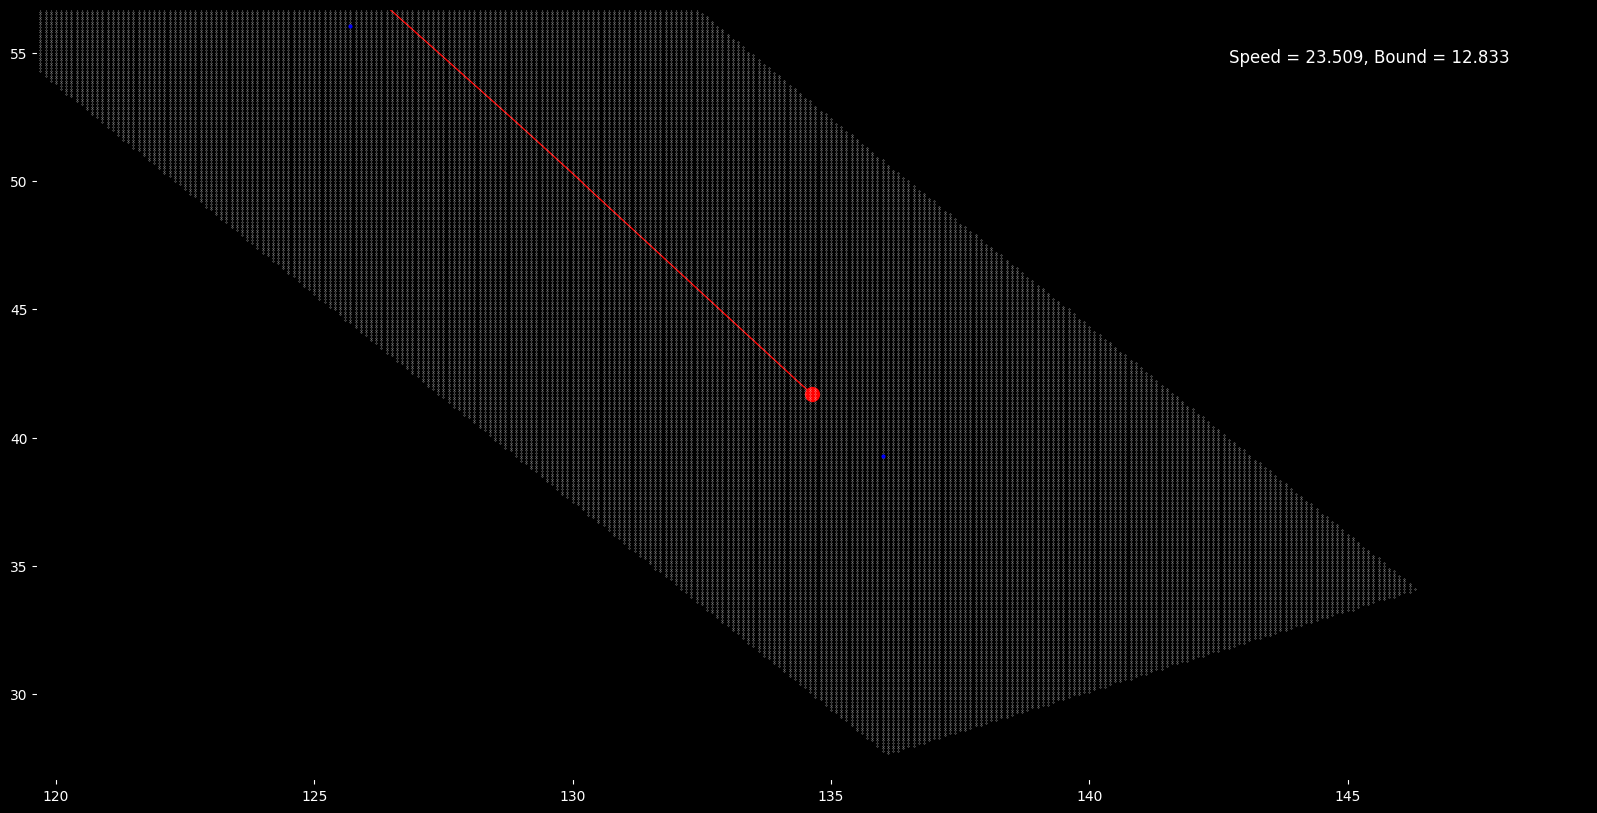

Final Position --  135.0858407725932 , 40.88418051173655 cm
Average Speed --  28.264957206676023  --  28.264957206676023 %
Total Time --  12.299999999999782 s
Average Wait --  -6.717502372118938 s


In [15]:

start_point = create_map(generate=False)
# start_point=(10,0)

accuracy_dist = 0.1

target_speed = 200

max_speed = 100

acceleration = max_speed/5

start_angle=45

gear_alpha = 0.01

max_error_angle=np.deg2rad(30)


POINT.set_point(start_point[0], start_point[1])
POINT.set_angle(np.deg2rad(start_angle) )
POINT.set_speed(0)
POINT.set_max_speed(max_speed)
POINT.set_acceleration(acceleration)
POINT.set_alpha(gear_alpha)
POINT.set_min_dist(accuracy_dist)
POINT.set_max_error_angle(max_error_angle)


simulate_particle(speed_up_ratio=target_speed/max_speed,
                delta_time=0.01,
                fps=25,
                y_axis=True,
                show_gif=True,
                x_bound=15,
                y_bound=15,
                stab_dist=2,
                max_trail=100)